# 필요한 라이브러리 import

In [197]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [198]:
import pandas as pd
from pandas import Series, DataFrame
import copy
from fbprophet import Prophet
import numpy as np
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error

In [199]:
def outliers_iqr(dataframe):
    data = dataframe['y']
    q1,q3 = np.percentile(data,[25,75])
    iqr = q3-q1
    lower = q1-(iqr*1.5)
    upper = q1+(iqr*1.5)
    return dataframe[(dataframe['y']>=lower ) & (dataframe['y']<=upper )]

In [200]:
Local20to21 = pd.read_csv('/content/drive/MyDrive/참외_롭다/Local.csv')
#Local20to21=pd.read_csv('Local.csv')
Local20to21.drop(['Unnamed: 0'],axis = 1,inplace = True)
Local20to21['date1'] = pd.to_datetime(Local20to21['date1'],format = '%Y-%m-%d')
Local20to21.head()

,생활지역권,date,남자20대이하,남자30대,남자40대,남자50대,남자60대,여자20대이하,여자30대,여자40대,여자50대,여자60대,date1
0,가락,2020-01-01,430884.9764,222389.0278,233416.4731,230651.4708,178417.6281,432150.6925,226525.7266,247073.9942,261086.8854,208436.9138,2020-01-01
1,가락,2020-01-02,463071.5891,219778.2503,234283.4328,226001.0335,178667.2016,446731.5830,224143.7966,253107.2972,271357.5782,213522.0869,2020-01-02
2,가락,2020-01-03,455526.7695,222279.2268,234046.6944,225537.6645,177935.2763,448736.3349,224880.6204,255023.7375,268877.0498,212935.5615,2020-01-03
3,가락,2020-01-04,448640.4068,227125.6133,241414.1611,234213.9029,177572.8638,461408.6045,227691.6905,256608.3360,269238.6376,211682.9452,2020-01-04
4,가락,2020-01-05,452730.9304,224497.8740,237907.8854,233570.4290,179469.9559,453607.9429,228226.9671,253961.6225,266464.0786,210569.8511,2020-01-05


In [201]:
test = copy.deepcopy(Local20to21[Local20to21['생활지역권']=='가산'][['date1','남자20대이하']])
test.rename(columns={'date1':'ds','남자20대이하':'y'},inplace = True)
test['y'] = test['y'] / 10000
test = outliers_iqr(test)

In [202]:
model = Prophet()
model.fit(test)

future_data = model.make_future_dataframe(periods=3, freq='m')
forecast_data = model.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
545,2021-06-29,21.459616,19.211926,23.677263
546,2021-06-30,21.051511,18.837105,23.361948
547,2021-07-31,13.432051,11.273450,15.629072
548,2021-08-31,21.458394,19.206982,23.773004
549,2021-09-30,21.042409,18.817529,23.328872


In [203]:
#결과값

a = np.mean(forecast_data['yhat'][-3:]) 
a 

18.644284819818704

In [204]:
df_cv = cross_validation(model, initial='500 days', period='10 days', horizon = '30 days')
df_cv.head()

INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-05-21 00:00:00 and 2021-05-31 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-05-22,13.356523,10.937605,15.626264,13.399131,2021-05-21
1,2021-05-23,12.919842,10.343760,15.235714,13.206317,2021-05-21
2,2021-05-24,20.884676,18.695386,23.203887,21.524927,2021-05-21
3,2021-05-25,21.395323,18.899319,23.930345,21.733848,2021-05-21
4,2021-05-26,20.944170,18.761418,23.378003,21.654964,2021-05-21


In [205]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,0.085050,0.291633,0.196615,0.010759,0.003994,1.0
1,4 days,0.162715,0.403380,0.334602,0.017116,0.018634,1.0
2,5 days,0.236630,0.486446,0.422987,0.020460,0.022205,1.0
3,6 days,0.205834,0.453690,0.413677,0.021722,0.021063,1.0
4,7 days,0.428948,0.654941,0.527536,0.026965,0.021063,1.0


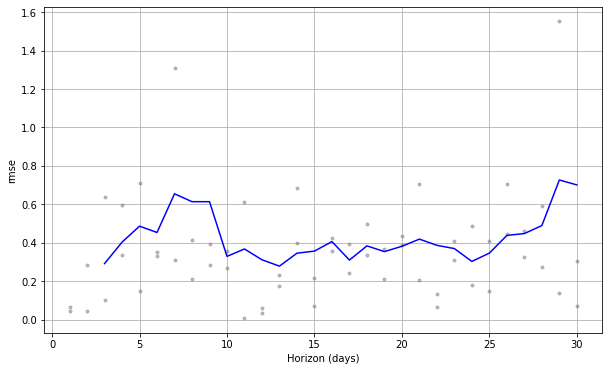

In [206]:
fig = plot_cross_validation_metric(df_cv, metric = 'rmse')

In [207]:
train = test.drop(test.index[-30:])
y_true = test['y'][-30:].values

# 모델 생성 후 학습
modeltrain = Prophet()
modeltrain.fit(train)

# train set 마지막 1년 날짜 생성
last_1year = []
for i in range(1, 31):
    last_1year.append(['2021-07-%02d' % i])
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])

# 예측하고 비교하기
# 여기에서는 MAE를 살펴본다.
forecast = modeltrain.predict(last_1year)
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)

print('MAE: %.3f' % mae)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 4.537


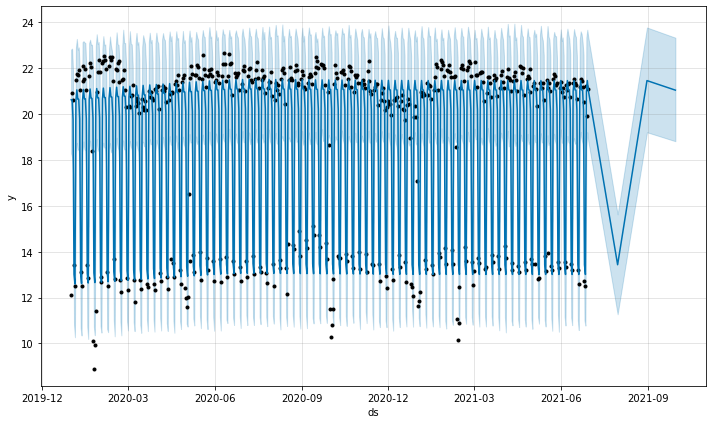

In [208]:
fig1 = model.plot(forecast_data)

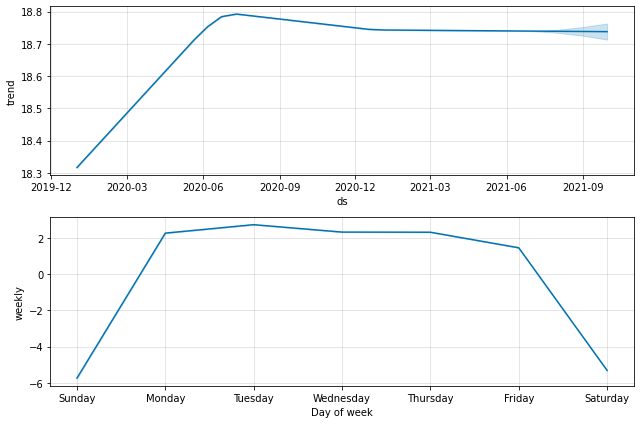

In [209]:
fig2 = model.plot_components(forecast_data)

In [210]:
dong = (Local20to21['생활지역권'].unique()) # 가산 가락 등
sexandage = (Local20to21.columns)[2:-1] #남자20대이하 여자30대 등

In [211]:
col = ['생활지역권','남자20대이하', '남자30대', '남자40대', '남자50대', '남자60대', '여자20대이하', '여자30대','여자40대', '여자50대', '여자60대']

In [ ]:
finalDF = pd.DataFrame(columns = col)


for enum, d in enumerate(dong[:]):
    templist = {'생활지역권': d}
    for sa in sexandage:
    #데이터 준비
      test = copy.deepcopy(Local20to21[Local20to21['생활지역권']==d][['date1',sa]])
      test.rename(columns={'date1':'ds',sa:'y'},inplace = True)
      test.y /= 10000


    #데이터 예측
      model = Prophet()
      model.fit(test)

      future_data = model.make_future_dataframe(periods=3, freq='m')
      forecast_data = model.predict(future_data)
      forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)




      templist[sa] = np.mean(forecast_data['yhat'][-3:]) #값을 여기에!

        
   
    tempDF = pd.DataFrame(columns = col,
                          data = templist,index = [enum])
    finalDF = pd.concat([finalDF , tempDF],ignore_index = True)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [ ]:
finalDF